In [1]:
# Matplotlib
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from matplotlib import animation

import seaborn as sns
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
sns.set(rc={"figure.figsize": (10, 10)})

# Break from default darkgrid for better printing on paper
sns.set_style("whitegrid")

# External Includes
from sklearn.datasets.samples_generator import make_moons
from sklearn.neighbors.kde import KernelDensity

from torch.autograd import Variable
from torch.nn import BCELoss
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset

# Internal Includes
from rfml.nn.model import Model
from rfml.nn.train import StandardTrainingStrategy, PrintingTrainingListener

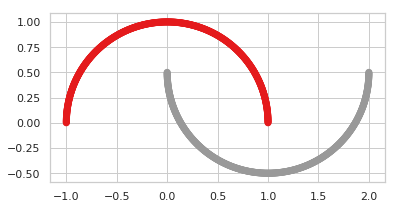

In [2]:
X, Y = make_moons(n_samples=1000, noise=None)

X = X.astype(np.float32)
Y = Y.astype(np.float32)

fig, ax = plt.subplots(1, 1)
ax.set_aspect("equal", "box")

ax.scatter(X[:,0], X[:,1], c=Y, cmap=get_cmap("Set1"))
plt.show()

In [3]:
class OvercomplicatedModel(Model):
    
    def __init__(self):
        super(OvercomplicatedModel, self).__init__(input_samples=2, n_classes=1)

        self.n1 = nn.Linear(2, 10000)
        self.a1 = nn.ReLU()
        self.n2 = nn.Linear(10000, 1000)
        self.a2 = nn.ReLU()
        self.n3 = nn.Linear(1000, 500)
        self.a3 = nn.ReLU()
        self.n4 = nn.Linear(500, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.n1(x)
        x = self.a1(x)

        x = self.n2(x)
        x = self.a2(x)

        x = self.n3(x)
        x = self.a3(x)

        x = self.n4(x)
        x = self.sigmoid(x)[:,0]

        return x

model = OvercomplicatedModel()

In [4]:
class MyTrainingStrategy(StandardTrainingStrategy):

    def __call__(
        self, model, training, validation
    ):
        criterion = BCELoss()

        if self.gpu:
            model.cuda()
            criterion.cuda()

        optimizer = Adam(model.parameters(), lr=self.lr)

        train_data = DataLoader(
            training, shuffle=True, batch_size=self.batch_size
        )
        val_data = DataLoader(
            validation, shuffle=True, batch_size=self.batch_size
        )

        # Fit the data for the maximum number of epochs, bailing out early if
        # the early stopping condition is reached.  Set the initial "best" very
        # high so the first epoch is always an improvement
        best_val_loss = 10e10
        epochs_since_best = 0
        best_epoch = 0
        for epoch in range(0, self.max_epochs):
            train_loss = self._train_one_epoch(
                model=model, data=train_data, loss_fn=criterion, optimizer=optimizer
            )
            self._dispatch_epoch_completed(mean_loss=train_loss, epoch=epoch)

            val_loss = self._validate_once(
                model=model, data=val_data, loss_fn=criterion
            )
            self._dispatch_validation_completed(mean_loss=val_loss, epoch=epoch)

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                epochs_since_best = 0
                best_epoch = epoch
                model.save()
            else:
                epochs_since_best += 1

            if epochs_since_best >= self.patience:
                break

        # Reload the "best" weights
        model.load()
        self._dispatch_training_completed(
            best_loss=best_val_loss, best_epoch=best_epoch, total_epochs=epoch
        )

In [5]:
trainer = MyTrainingStrategy(batch_size=128)
trainer.register_listener(PrintingTrainingListener())

In [6]:
split_idx = 100
training = TensorDataset(torch.from_numpy(X[:split_idx,:]), torch.from_numpy(Y[:split_idx]))
validation = TensorDataset(torch.from_numpy(X[split_idx:,:]), torch.from_numpy(Y[split_idx:]))
trainer(model, training, validation)

Epoch 0 completed!
		-Mean Training Loss: 0.692
		-Mean Validation Loss: 0.369
Epoch 1 completed!
		-Mean Training Loss: 0.394
		-Mean Validation Loss: 1.957
Epoch 2 completed!
		-Mean Training Loss: 1.919
		-Mean Validation Loss: 0.277
Epoch 3 completed!
		-Mean Training Loss: 0.308
		-Mean Validation Loss: 0.704
Epoch 4 completed!
		-Mean Training Loss: 0.738
		-Mean Validation Loss: 0.675
Epoch 5 completed!
		-Mean Training Loss: 0.701
		-Mean Validation Loss: 0.471
Epoch 6 completed!
		-Mean Training Loss: 0.495
		-Mean Validation Loss: 0.377
Epoch 7 completed!
		-Mean Training Loss: 0.343
		-Mean Validation Loss: 0.221
Epoch 8 completed!
		-Mean Training Loss: 0.244
		-Mean Validation Loss: 0.207
Epoch 9 completed!
		-Mean Training Loss: 0.202
		-Mean Validation Loss: 0.215
Epoch 10 completed!
		-Mean Training Loss: 0.232
		-Mean Validation Loss: 0.235
Epoch 11 completed!
		-Mean Training Loss: 0.237
		-Mean Validation Loss: 0.214
Epoch 12 completed!
		-Mean Training Loss: 0.187
	

In [7]:
def generateGrid(spacing=0.25):
    xp = np.arange(-1.5, 2.25, spacing).astype(np.float32)
    yp = np.arange(-1, 1.25, spacing).astype(np.float32)
    x,y = np.meshgrid(xp, yp)
    return x, y

def getOutputs(x, y, net):
    z = np.zeros(x.shape)
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            example = np.stack((x[i,j],y[i,j])).T[np.newaxis,:]
            temp = net(torch.from_numpy(example))
            temp = temp[0]
            z[i, j] = temp.detach().numpy()>0.5
    return z

def plotOutputs(ax, x, y, z):
    cmap = plt.get_cmap('Set1')
    CS = ax.pcolormesh(x, y, z, cmap=cmap, alpha=0.25)
    return CS

In [8]:
model.cpu()

x, y = generateGrid(spacing=0.025)
z = getOutputs(x, y, model)

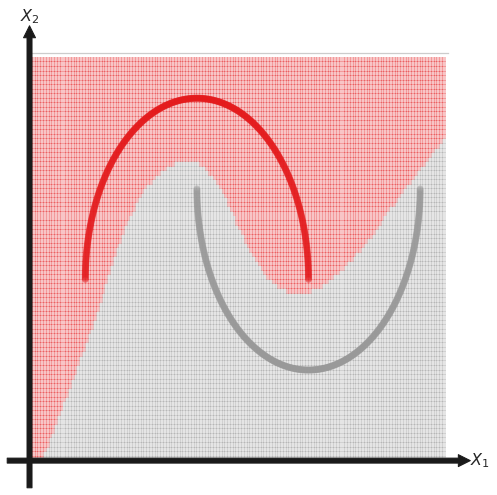

In [11]:
fig, ax = plt.subplots(1,1, figsize=(7.5,7.5))

# plotting decision regions
CS = plotOutputs(ax, x, y, z)

# Plot the true data on top
ax.scatter(X[:,0], X[:,1], alpha=0.3, c=Y[:], cmap=get_cmap("Set1"))

ax.set_xlim(-1.5, 2.25)
ax.set_ylim(-1, 1.25)

for side in ['bottom','right']:
    ax.spines[side].set_visible(False)

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()

_ = ax.annotate("", xy=(xmax + 0.2, ymin), xytext=(xmin -0.2, ymin), annotation_clip=False,
                arrowprops={"width": 5.0, "facecolor": "k", "edgecolor": "k"})
_ = ax.text(xmax + 0.2, ymin, r"$X_1$",
            fontsize=16, fontstyle="italic", fontweight="bold",
            horizontalalignment="left", verticalalignment="center")

_ = ax.annotate("", xy=(xmin, ymax+0.15), xytext=(xmin, ymin - 0.15), annotation_clip=False,
                arrowprops={"width": 5.0, "facecolor": "k", "edgecolor": "k"})
_ = ax.text(xmin, ymax+0.15, r"$X_2$",
            fontsize=16, fontstyle="italic", fontweight="bold",
            horizontalalignment="center", verticalalignment="bottom")

plt.show()

fig.savefig("/home/bflowers/toy-adversarial.pdf", format="pdf", transparent=False)